# Medical Project
### Lars Olsen and Oda Kristensen

In this project we are given we are given a dataset of 10 000 patients. Each patient $\textit{t}$ has attributes $x_t = \{x_{t,1},x_{t,2},\dots, x_{t,130}\}$, where $x_{t,1}$ represents the gender, $x_{t,2}$ represents the whether or not the patient smoke, $\{x_{t,3},\dots,x_{t,128}\}$ represents the patient's genes and $\{x_{t,129},x_{t,130}\}$ represents the symptoms the patient displays. Note that all the variables are binary, that is $x_{t, \cdot } \in \{ 0,1\}$. We are also given the historical action $a_t \in \{ 0,1\}$ which represents whether the patient was given a placebo or an active treatment, respectively. Finally, we are given the historical outcome $y_t\in \{ 0,1\}$, whether the patient displayed measurable effects after the treatment. Note that later in the project, part 3, we will expand the action variable to take on values between 0 and 129, that is, $a_t \in \{ 0,1,2,\dots,129\}$. Where action 2 represents a new general treatment while the remaining treatments are gene specific treatments. I.e. they are more effective if the patient has certain genes.

Throughout this project we want to find a policy that maximizes the utility, given by the mean of the rewards. 
$$\text{Utility} = \frac{1}{T}\sum_t^T r_t = \frac{1}{T}\sum_t^T (-0.1a_t + y_t).$$

The reward function implies that there is a small penalty associated with the use of an active treatment. Thus, the policy should be somewhat certain that an active treatment will yield a positive result before recommending it. If we omit this term, all our models recommend the treatment 100% of the time, since the estimated reward of the treatment is higher than the placebo, as we will come back to soon. This penalty can reflect the cost of a treatment. $$\textbf{Say that treatment 1 is cheaper than treatment 2, but the second treatment is better. Then we should use the cheap one when we think that it suffices. When we do not think it is adequate we will use the second treatment.}$$ Usikker på formulering

Later, when we introduce the new actions we let the penalty be the same for all treatments. That is, we do not use the value of $a_t$, but apply the penealty of $-0.1$ if we use a treatment. It is not realistic that all the treatments have the same cost, but if we use the action above we get that $a_t = 100$ will yield a reward of $-10$ or $-9$ depending on the outcome. Since we want to maximize the utility we will never end up using the actions correnspong to a high $a_t$. We did not want to make up random cost for each drug, hence we choose a fixed cost for all the treatments.

We start by importing some packages and modules:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from scipy.stats import norm
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

We read the files:

In [4]:
features = pd.read_csv('historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('historical_Y.dat', header=None, sep=" ").values

In this part of the project we are only interested in the features. The first 128 features are ($$\textbf{what we observe}$$); sex, smoker and 126 genes. The 2 last attributes are the symptoms and these can be taken to be akin to labels in supervised learning.

In [5]:
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

We take a look at the observations of the 1st patient, sex = 0, and non smoker.

In [6]:
observations[0]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0])

We divide our data set into traning and test sets.

In [7]:
obs_train, obs_test, lab_train, lab_test = train_test_split(observations, labels, test_size=0.25)

Let's look at the distribution of symptoms: $$\textbf{forklar hva 0,1,2,3 betyr}$$


(array([3641.,    0.,    0., 3126.,    0.,    0.,  408.,    0.,    0.,
         325.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

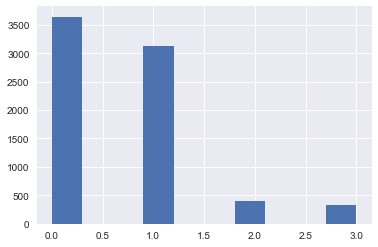

In [8]:
plt.hist(lab_train)

We now take a look at the histogram of observation. 

([array([3740.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3760.]),
  array([5473.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2027.]),
  array([3725.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3775.]),
  array([3691.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3809.]),
  array([3723.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3777.]),
  array([3804.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3696.]),
  array([3751.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3749.]),
  array([3731.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3769.]),
  array([3803.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3697.]),
  array([3822.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3678.]),
  array([3707.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3793.]),
  array([3

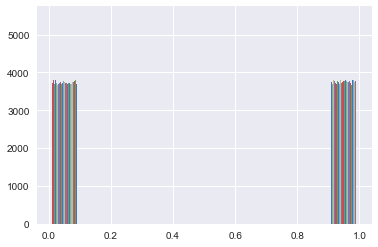

In [9]:
plt.hist(obs_train) #Fjerne?

$$\textbf{We talked to Summaya Mumtaz in the lab and she said that from this plot we could se that there are two clusters. We are not sure how she did that. For us it just seems that each attribute takes either the value of zero or one, as we know they do from the definition of the data. If we look at only one attribute at the time we agreee that we have two clusters.} Take $x_2$, either they smoke ($x_2=1$) or not ($x_2=0$), so we have to clusters. But when we have more dimensions I feel like we have more clusters. $$
Since we have 130 features, with two possible values each, there are $$2^{130}$$ $$\textbf{2^128?}$$ possible, unique patients. We want to examine if we can find some pattern in the data, i.e if there we can divide the patients into different clusters. We use the k-means algorithm to divide the data into $$k$$ clusters, and find optimal $$k$$ by silhouette score and elbow method of k-means score. 
$$\textbf{Say we look at the two first attributes. Then a person can be either male or female and the can smoke or not smoke, i.e. we have four potential combinations. Thi of a square with a cluster in each corner. obviously it can be that there are no female smokers. Then we have three clusters. Then we can think of the clusters as being on a line. Male smokers are more similar to male non-smokers than female non-smokers, and male non-smokers are equally similar to both (assuming equal weighting of the attributes). So we have "male smokers" -- "male non-smokers" -- "female non-smokers". In a hypercube we would still have clusters in each corner, and this gives us $2^{128}$ potential clusters. This is an astronomical number. So we must assume that there is pattern in the data, which will lower this number.}$$ 

$$\tectbf{From the two histograms bellow we see that there are more people of the sex zero and more non-smokers.}

/Users/Oda/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


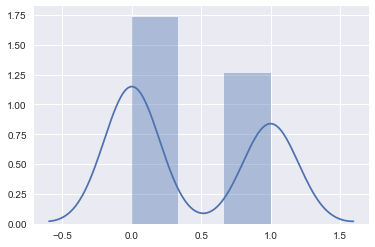

In [10]:
sns.distplot(obs_train[0])

/Users/Oda/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


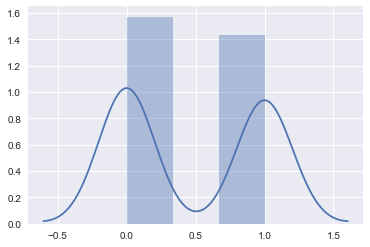

In [11]:
sns.distplot(obs_train[1])

Let's look at the proportions of smokers among sex 0. 

/Users/Oda/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


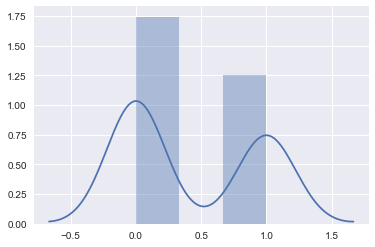

In [12]:
sns.distplot(obs_train[1][obs_train[0] == 0])

Let's look at the proportions of smokers among sex 1.

/Users/Oda/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


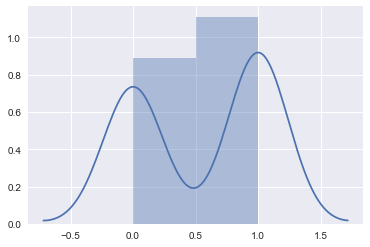

In [13]:
sns.distplot(obs_train[1][obs_train[0] == 1])

We see that there is a higher percentage of sex=0 that smoke than sex=1 that smoke.

### Let's now take a look at the scores with Kmeans

In [14]:
elbows_score = np.zeros(21) 
for k in range(1,21):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(obs_train)
    
    # Sum of distances of samples to their closest cluster center.
    inertia = kmeans_model.inertia_
    
    elbows_score[k] = inertia/k
    
    print("k = %2d: Inertia = %f   Score = %f   Elbow = %f" % (k,inertia,kmeans_model.score(obs_test), inertia/k))

k =  1: Inertia = 239530.040533   Score = -79860.111822   Elbow = 239530.040533
k =  2: Inertia = 217779.937464   Score = -72570.863445   Elbow = 108889.968732
k =  3: Inertia = 206083.648173   Score = -68604.951740   Elbow = 68694.549391
k =  4: Inertia = 197955.859868   Score = -66150.651903   Elbow = 49488.964967
k =  5: Inertia = 191794.263557   Score = -63998.689036   Elbow = 38358.852711
k =  6: Inertia = 186464.194035   Score = -62265.025700   Elbow = 31077.365673
k =  7: Inertia = 182228.175592   Score = -60734.196750   Elbow = 26032.596513
k =  8: Inertia = 178393.891830   Score = -59474.614562   Elbow = 22299.236479
k =  9: Inertia = 175202.665147   Score = -58467.621155   Elbow = 19466.962794
k = 10: Inertia = 172654.861569   Score = -57790.503981   Elbow = 17265.486157
k = 11: Inertia = 170111.329787   Score = -57227.917135   Elbow = 15464.666344
k = 12: Inertia = 168096.731698   Score = -56425.531495   Elbow = 14008.060975
k = 13: Inertia = 165775.322319   Score = -55651.6

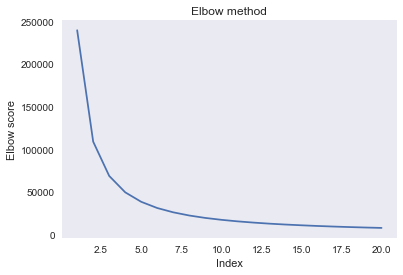

In [15]:
x = np.array([i for i in range(1,21)])

fig, ax = plt.subplots()
ax.plot(x, elbows_score[1:21])

ax.set(xlabel='Index', ylabel='Elbow score',
       title='Elbow method')
ax.grid()
plt.show()

We want this score as high as possible. The k with the best score is the k we should chose, i.e. the optimal number of clusters. The problem is that this score will keep incresing to zero when k increase. This is because score look at the distance from each point to the closest cluster centrum (for the test data, Ineteria does the same for the training data), and train and test set takes the same possible values this is a problem. Since then $2^{128}$ will (potentially) be the best k. Usually this score starts to level of, that the increase in absolute value decrese. So one can usually pick a resoanble K, but we are unsure where such a cap should be choosen here. Interia is much bigger due to the bigger dataset. One need to look at -score.

Say that K = 6 is a nice treeshold. We take a closer look at K = 6.

In [16]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(obs_train)

In [17]:
kmeans_model.score(obs_test)

-62265.025700011116

In [18]:
for l in range(6):
    print("Number of people in cluster %d: %d" %(l,sum(kmeans_model.labels_ == l)))

Number of people in cluster 0: 1155
Number of people in cluster 1: 1369
Number of people in cluster 2: 1181
Number of people in cluster 3: 1271
Number of people in cluster 4: 1344
Number of people in cluster 5: 1180


We see that the people are fairly evenly divided between the clusters.

$$\textbf{droppe?}$$

In [19]:
for k in range(1,21):
    gm_model = GaussianMixture(n_components=k, max_iter = 200, random_state=1).fit(obs_train)
    
    print("k = %2d: Score = %f" % (k, gm_model.score(obs_test)))

k =  1: Score = -32.420980
k =  2: Score = -27.007115
k =  3: Score = -21.844072
k =  4: Score = -22.212879
k =  5: Score = -17.890017
k =  6: Score = -20.931649
k =  7: Score = -17.027358
k =  8: Score = -16.388413
k =  9: Score = -17.284388
k = 10: Score = -19.359296
k = 11: Score = -17.319460
k = 12: Score = -13.422147
k = 13: Score = -19.144791
k = 14: Score = -14.426294
k = 15: Score = -16.424677
k = 16: Score = -19.966242
k = 17: Score = -20.342668
k = 18: Score = -20.559779
k = 19: Score = -23.291779
k = 20: Score = -23.362581


We now do the same as before but also take a look at the Bic score to find the optimal value. We have done this because of. http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py It was wrong of us to look at BicTest. One should only look at BicTrain. The optimal value is 3. But, 2 is not far of. And since we know that is the truth we go for it.

In [17]:
for k in range(1,10):
    gm_model = GaussianMixture(n_components=k, max_iter = 200, random_state=1).fit(obs_train)
    bic = gm_model.bic(obs_train)
    aic = gm_model.aic(obs_train)
    print("k = %2d: ScoreTrain = %.3f   ScoreTest = %.3f   Bic = %.3f   Aic = %.3f" % (k, gm_model.score(obs_train),gm_model.score(obs_test), bic, aic))

k =  1: ScoreTrain = -31.373   ScoreTest = -32.359   Bic = 545399.189   Aic = 487359.622
k =  2: ScoreTrain = -24.810   ScoreTest = -26.926   Bic = 521777.915   Aic = 405691.858
k =  3: ScoreTrain = -20.511   ScoreTest = -24.019   Bic = 532103.217   Aic = 357970.670
k =  4: ScoreTrain = -17.173   ScoreTest = -22.056   Bic = 556844.621   Aic = 324665.584
k =  5: ScoreTrain = -13.436   ScoreTest = -19.714   Bic = 575616.057   Aic = 285390.530
k =  6: ScoreTrain = -12.238   ScoreTest = -20.020   Bic = 632465.142   Aic = 284193.125
k =  7: ScoreTrain = -9.678   ScoreTest = -218.665   Bic = 668870.530   Aic = 262552.023
k =  8: ScoreTrain = -7.701   ScoreTest = -217.959   Bic = 714044.179   Aic = 249679.183
k =  9: ScoreTrain = -1.213   ScoreTest = -12.901   Bic = 691539.330   Aic = 169127.844


From the values above we see that k=13 is the best choice, but k=6 is not that far off, and since 6 is much lower we conclude that with Gaussian Mixture models the 'optimal' choice is 6 clusters. If we look at the score. But AIC and BIC is betther. Here we see that 2 or 3 is optimal.

In [19]:
gm_model = GaussianMixture(n_components=2, max_iter = 200, random_state=1).fit(obs_train)

In [ ]:
gm_model.predict(obs_)


#### We look at kmeans_silhouette_analysis

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [122]:
for n_clusters in range(2,11):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(obs_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(obs_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.08789046555225062
For n_clusters = 3 The average silhouette_score is : 0.07400565765849043
For n_clusters = 4 The average silhouette_score is : 0.06795148893837454
For n_clusters = 5 The average silhouette_score is : 0.06463853037241843
For n_clusters = 6 The average silhouette_score is : 0.06346335792308268
For n_clusters = 7 The average silhouette_score is : 0.06442224067814628
For n_clusters = 8 The average silhouette_score is : 0.06535853448402974
For n_clusters = 9 The average silhouette_score is : 0.06588064103198324
For n_clusters = 10 The average silhouette_score is : 0.06493274114857885


We see that the score stabilize after 4 clusters.

# Final choice of clusters and features
In the R file OptimalKAndFeatureImportance.R we have calculated the best choice of K and the most important features, based on SilhouetteScore and the importance score from randomforest, respectively. From now on we use the values obtained there. We got that 2 is the optimal number of clusters (see SilhouetteScore.png and SilhouetteScoreAfterFeatureReduction.png). This gives an average silhouette score of 0.088. The silhouette score of a point is 1, if it is very well separated from the neighbouring cluster, and 0 if it is on, or very near the border of a neighbouring cluster. From the definition of silhouette score, we see that the average score of 0.08 is quite small, and so it does not indicate very separated clusters. 

Using $\textbf{random forrest}$ we got that $x_{6}$, $x_4$, $x_{114}$, $x_{12}$, $x_{84}$, $x_2$ and $x_{56}$ are the most important features, in that order. Recall that python counts from 0, so this means columns 5, 3, 113, 11, 83, 1 and 55. 

Next, we want to explore the differences between the patients belonging to the two different clusters. $\textbf{We start by dividing the people into 2 clusters. fjerne?}$

In [24]:
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(obs_train)

In [26]:
kmeans_model.labels_

array([0, 0, 1, ..., 1, 0, 0])

In [36]:
train_obs_0 = obs_train[kmeans_model.labels_ == 0]
train_obs_1 = obs_train[kmeans_model.labels_ == 1]
train_lab_0 = lab_train[kmeans_model.labels_ == 0]
train_lab_1 = lab_train[kmeans_model.labels_ == 1]

In [32]:
train_obs_0.shape

(3609, 128)

In [40]:
train_lab_0.shape

(3609,)

We now plot the histogram and see that there are more people with $$\textbf{symptoms 1 and 3}$$  in the 0 cluster. 
And there are more people with $$\textbf{symptoms 0 and 2} $$in cluster 1.

(array([1269.,    0.,    0., 2071.,    0.,    0.,   95.,    0.,    0.,
         174.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

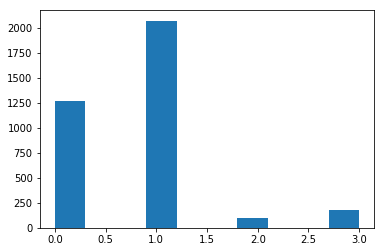

In [38]:
plt.hist(train_lab_0)

(array([2338.,    0.,    0., 1086.,    0.,    0.,  327.,    0.,    0.,
         140.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

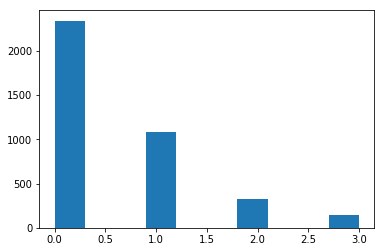

In [39]:
plt.hist(train_lab_1)

# Question 2

Next, we want to observe the effects of two different therapeutic interventions, one of which is placebo, and the other is an experimental drug. First we calculate the success of the two treatments in the whole data set. Here we assume that treatment 0 is placebo and treatment 1 is active treatment, but it could very well be the other way around. We also assume that Y = 1 means that the patient is cured, and Y = 0 means that the patient is not cured. 

In [76]:
#I want pandas
features = pd.read_csv('historical_X.dat', header=None, sep=" ")
actions = pd.read_csv('historical_A.dat', header=None, sep=" ")
outcome = pd.read_csv('historical_Y.dat', header=None, sep=" ")


active_treatments = 0
success_placebo = 0
success_active = 0

active_treatments = sum(actions.loc[:,0])


for i in range(len(actions)):
    if actions.loc[i,0] == 1 and outcome.loc[i,0] == 1:
        success_active += 1
    elif actions.loc[i,0] == 0 and outcome.loc[i,0] == 1:
        success_placebo += 1


print("The effectiveness of placebo is: %f " %(success_placebo/(10000-active_treatments)))
print("The effectiveness of active treatment is: %f " %(success_active/(active_treatments)))

The effectiveness of placebo is: 0.008959 
The effectiveness of active treatment is: 0.588338 


We see that the treatment is effective in 58.8% of the cases for treatment 1, and 0.9% effective for treatment 0. 

Next, we want to investigate whether there are some parameters that effect the outcome of the treatment. I.e. if there are some genes or other parameters that affect the effect of the treatment. From previous parameter selection, we found that the most important features were $X_2$, $X_4$, $X_6$, $X_{12}$, $X_{56}$, $X_{84}$, $X_{114}$. To find out if there is some interaction between some parameters, we choose these features and also include the action feature, and do logistic regression for models with interactions with parameter selection. For code see $\texttt{LogRegInteract.R}$

The text above is the output from R after we have done a parameter selection using BIC, allowing interactions of second order. We see here that the only interaction term including $A$, kept by the feature selection is the interaction between $X_84$ and $A$. The interaction term is positive, meaning that the treatment is more successfull when the $X_84$ feature is present. We repeat this process, but this time using AIC as selection criterion and get the following model. 


From this model, it does not seem like any features have a negative interaction with $A$, meaning that treatment1 will be effective for all features. However we do observe that some features and some feature combinations seems to have a negative effect on the result of the treatment. In both the AIC and the BIC model, the presence of the $X2$ feature influences the result of the treatment in a negative way, meaning that these patients are less likely of being cured. Also, both models indicate that the feature combination of $X_4$ and $X_6$ influence the result of the treatment in a negative way. Based on this, we would always recommend the active treatment.  

We would also like to investigate whether the clusters found by K-means clustering are affected differently by the treatment. We found that two clusters were the optimal number of clusters. We choose to do this on the whole data set, so that all the data are divided into one of the two clusters. We are not sure whether this is the correct approach, or if we should only fit the test data, so please correct us if we are wrong. For this, we repeat the procedure of the first part of Question 2, but this time dividing the data into the two clusters. 

In [138]:
# First fit a K-means
kmeans = KMeans(n_clusters = 2, random_state = 1).fit(obs_train)

#Divide observations into two clusters. 
cluster = kmeans.predict(observations)  
index_cluster0 = np.where(cluster == 0) 
index_cluster1 = np.where(cluster == 1)

actions_cluster0 = actions.iloc[index_cluster0]
outcome_cluster0 = outcome.iloc[index_cluster0]

actions_cluster1 = actions.iloc[index_cluster1]
outcome_cluster1 = outcome.iloc[index_cluster1]

active_treatments0 = sum(actions_cluster0.loc[:,0])
active_treatments1 = sum(actions_cluster1.loc[:,0])

#First cluster 0:
#Successfull and active treatments if both are 1
success_active0 = np.sum(np.multiply(actions_cluster0.values, outcome_cluster0.values))
#Successfull, active treatments if outcome is 1, but active is 0
success_placebo0 = np.sum(outcome_cluster0.values) - success_active0

print("The effectiveness of placebo in cluster 0 is: %f " %(success_placebo0/(actions_cluster0.shape[0]-active_treatments0)))
print("The effectiveness of active treatment in cluster 0 is: %f " %(success_active0/(active_treatments0)))        

#Cluster 1
success_active1 = np.sum(np.multiply(actions_cluster1.values, outcome_cluster1.values))
success_placebo1 = np.sum(outcome_cluster1.values) - success_active1

print("The effectiveness of placebo in cluster 1 is: %f " %(success_placebo1/(actions_cluster1.shape[0]-active_treatments1)))
print("The effectiveness of active treatment in cluster 1 is: %f " %(success_active1/(active_treatments1)))        

The effectiveness of placebo in cluster 0 is: 0.001202 
The effectiveness of active treatment in cluster 0 is: 0.470206 
The effectiveness of placebo in cluster 1 is: 0.018064 
The effectiveness of active treatment in cluster 1 is: 0.667636 


We see that the a bigger proportion of patients in cluster 1 are cured than in cluster 0, this apply both to the active treatment and the placebo treatment.   

As we saw in $\texttt{SilhouetteScoreAfterFeatureReduction.png}$, the clusters were more separated when we only kept the most important features. Maybe the differences in effect of treatment between the two clusters will be even more apparent if we cluster the observations based on only these most important features. 

In [143]:
important_features = features[[1, 3, 5, 55, 83 , 113]]
if_train, if_test = train_test_split(important_features, test_size=0.25)

kmeans_if = KMeans(n_clusters=2, random_state=1).fit(if_train)
cluster_if = kmeans_if.predict(important_features)


index_cluster0_if = np.where(cluster_if == 0) 
index_cluster1_if = np.where(cluster_if == 1)

actions_cluster0_if = actions.iloc[index_cluster0_if]
outcome_cluster0_if = outcome.iloc[index_cluster0_if]

actions_cluster1_if = actions.iloc[index_cluster1_if]
outcome_cluster1_if = outcome.iloc[index_cluster1_if]


active_treatments0_if = sum(actions_cluster0_if.loc[:,0])
active_treatments1_if = sum(actions_cluster1_if.loc[:,0])


#First cluster 0:
#Successfull and active treatments if both are 1
success_active0_if = np.sum(np.multiply(actions_cluster0_if.values, outcome_cluster0_if.values))
#Successfull, active treatments if outcome is 1, but active is 0
success_placebo0_if = np.sum(outcome_cluster0_if.values) - success_active0_if


print("The effectiveness of placebo in cluster 0 is: %f " %(success_placebo0_if/(actions_cluster0_if.shape[0]-active_treatments0_if)))
print("The effectiveness of active treatment in cluster 0 is: %f " %(success_active0_if/(active_treatments0_if)))        


#Cluster 1
success_active1_if = np.sum(np.multiply(actions_cluster1_if.values, outcome_cluster1_if.values))
success_placebo1_if = np.sum(outcome_cluster1_if.values) - success_active1_if

print("The effectiveness of placebo in cluster 1 is: %f " %(success_placebo1_if/(actions_cluster1_if.shape[0]-active_treatments1_if)))
print("The effectiveness of active treatment in cluster 1 is: %f " %(success_active1_if/(active_treatments1_if)))        






The effectiveness of placebo in cluster 0 is: 0.010493 
The effectiveness of active treatment in cluster 0 is: 0.578473 
The effectiveness of placebo in cluster 1 is: 0.007727 
The effectiveness of active treatment in cluster 1 is: 0.614173 


These numbers are different from the ones we got previously, when all the features were included. We were hoping to find bigger differences between the clusters using only the most important features, however, the effect of the treatment is more similar between the two clusters when the observations are clustered only by the important features. 

$\textbf{I oppgaven spør han "Are there perhaps cases where 
          the active treatment is never effective, [...] ". Det vet vi jo at det er etter å ha gjort del 2/3, men har vi noen forutsetning for å kunne si det allerede her?}?$

# Part two

### Exercise 1 (Meassuring utility)

#### 1. Measure the utility of $\pi_0$ on the historical data.

In [20]:
# Actions is an array of 0's and 1's, representing 'placebo' and 'experimantal drug', respectively.
print(actions)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [21]:
# Outcome is an array of 0' and 1's, representing 'no effect' and 'measurable effect', respectively.
print(outcome)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


The utility function is given as
$$\sum_t r_t = \sum_t (-0.1a_t + y_t).$$
Here the -0.1 factor implies that the active treatment must be at least 10% more effective than the placebo for the utility to be better for the experimental drug than the placebo. We look at the utility of $\pi_0$ on the historical data.

In [22]:
U = np.sum(-0.1*actions + outcome)/len(outcome)
U

0.11912

We see that the utility is 0.11912. $$\textbf{We are not confident on wheter or not this is a good result. One should note that $t$ span from 1 to 10 000. So the maximal utility we can achieve is 10 000. However, it that scenario we give placebos to all the patients and we see a measuarble effect in all of them, which is highly unlikely.}$$ Because of our utility function, giving a patient the active treatment decrease the utility if the patient is not cured. 


The exercise asks for the expected utility. We cannot calculate it exactly, but we can estimate it from the data. That is what we have done above. Below we describe it futher.
$$\hat{E[U]} = E_{data}[U] = \sum_t (-0.1E_{data}[a_t] + E_{data}[y_t])$$ where $E_{data}[a_t] = \sum(0p(a_t=0) + 1p(a_t=1)) = \sum (\frac{\# a_t = 1}{\# a_t})$ and $E_{data}[y_t] = \sum(0p(y_t=0) + 1p(y_t=1)) = \sum (\frac{\# y_t = 1}{\# y_t})$.

In [70]:
perc1out = np.sum(outcome==1)/len(outcome)
perc1out 

0.1421

In [71]:
perc1act = np.sum(actions==1)/len(actions)
perc1act

0.2298

$\textbf{droppe kode under, siden jeg har endret på utility-funksjonen?}$


In [24]:
10000*(-0.1*perc1act + perc1out)

NameError: name 'perc1act' is not defined

Which was the same as we got above, as expected.
We have also implemented this in the python file we have delivered.
Simply call policy.estimate_utility(features, actions, outcome).

#### 2. Provide error bounds on the expected utility
To provide error bounds on the expected utility we use bootstraping. We create $B$ datasets by sampling from the original data $10 000$ times with replacement. For each of the $B$ dataset we calculate the expected utility. To get, let's say, a 95% error bound we look at the 2.5% and 97.5% quantile.

In [28]:
B = 500
results = np.zeros(B)

for b in range(B):
    n = len(outcome)
    indices = np.random.choice(n, n)
    outcome_bootstrap = outcome[indices]
    action_bootstrap = actions[indices]
    results[b] = np.sum(-0.1*action_bootstrap + outcome_bootstrap)/len(outcome_bootstrap)

In [29]:
bounds = np.percentile(results, [2.5, 97.5])
bounds

array([0.1126595 , 0.12503525])

From this we see that a 95% CI for the utility is $\textbf{[1127.9075, 1261.5225], endre intervalll etter at utilty-funksjon er endret}$. So the utility of $\pi_0$ is well inside these error bounds.

### Exercise 2 (Improved policies)


### 1.

We want to improve the policy, so that we can increase the utility. For the model, we choose a neural network and logistic regression, which we fit by first making an object of the classes $\texttt{NNRecommender}$ and $\texttt{LogisticRecommender}$, in the file $\texttt{TestRecommender.py}$, where we set the reward function to what it is defined as in the project description. We then call the policies' $\texttt{fit_treatment_outcome}$-function, so that our policies are trained on the historical data. To find the estimated utility of these improved models, we call $\texttt{policy_NN.estimate_utility(features, None, None, policy.NN)}$ and $\texttt{policy_logistic.estimate_utility(features, None, None, policy.logistic)}$. Note that when a $\texttt{policy}$ argument is given to the $\texttt{estimate_utility}$-function, the $\texttt{policy}$ will recommend an action, and it is these actions (and the probabilities of the different outomes) that are used to calculate the estimated utility.   

### 2.


Run $\texttt{TestRecommender.py}$ to see the results. Below you can see the last printout from $\texttt{TestRecommender.py}$. From this we see that both logistic regression and neural network are better than the historical policy.

In [7]:
import pandas

features = pandas.read_csv('historical_X.dat', header=None, sep=" ").values
actions = pandas.read_csv('historical_A.dat', header=None, sep=" ").values
outcome = pandas.read_csv('historical_Y.dat', header=None, sep=" ").values
n = features.shape[0]

import NNRecommender
policy_factory_NN = NNRecommender.NNRecommender
policy_NN = policy_factory_NN(2, 2)

import LogisticRecommender
policy_factory_logistic = LogisticRecommender.LogisticRecommender
policy_logistic = policy_factory_logistic(2, 2)

def reward_function(action, outcome):
    return -0.1*action + outcome

# First we need to set the reward
policy_NN.set_reward(reward_function)
policy_logistic.set_reward(reward_function)

## Fit the policy on historical data 
policy_NN.fit_treatment_outcome(features, actions, outcome)
policy_logistic.fit_treatment_outcome(features, actions, outcome)

# Utility of the historical policy. Deterministic, so no difference if we call with policy_NN or policy_logistic
utility_hist = policy_NN.estimate_utility(features, actions, outcome)/n

# Utility of new policy
utility_new_policy_NN = policy_NN.estimate_utility(features, None, None, policy_NN)/n
utility_new_policy_logistic = policy_logistic.estimate_utility(features, None, None, policy_logistic)/n

# Utility of improved policy, using a neural network trained on the historical data
print("\nThe historical utility was %2f" %(utility_hist))
print("The estimated utility of the improved NN policy is: %2f " % (utility_new_policy_NN))
print("The estimated utility of the improved logistic policy is: %2f"  % (utility_new_policy_logistic))

Fitting treatment outcomes
Neural Network estimating utility   1000 of 10000
Neural Network estimating utility   2000 of 10000
Neural Network estimating utility   3000 of 10000
Neural Network estimating utility   4000 of 10000
Neural Network estimating utility   5000 of 10000
Neural Network estimating utility   6000 of 10000
Neural Network estimating utility   7000 of 10000
Neural Network estimating utility   8000 of 10000
Neural Network estimating utility   9000 of 10000
Neural Network estimating utility  10000 of 10000
Logistic model estimating utility   1000 of 10000
Logistic model estimating utility   2000 of 10000
Logistic model estimating utility   3000 of 10000
Logistic model estimating utility   4000 of 10000
Logistic model estimating utility   5000 of 10000
Logistic model estimating utility   6000 of 10000
Logistic model estimating utility   7000 of 10000
Logistic model estimating utility   8000 of 10000
Logistic model estimating utility   9000 of 10000
Logistic model estimati

$$\textbf{The historical utility was 1191.200000
The estimated utility of the improved NN policy is: 4606.017435 
The estimated utility of the improved logistic policy is: 4273.185857. Dette er vel utdatert?}$$

# Part 3 - Adaptive experiment design

In this part part we are going to test our recommenders on new patients and evaluate the results. We do this by using the $\texttt{test_policy}$ function. It creates a fixed number of patients, ask the recommenders what treatments each indivdual should recive and then calculate the outcome. At the end it let the recommender obsereve the outcome. 

In [10]:
def test_policy(generator, policy, reward_function, T, seed = None, printout = False):
    policy.set_reward(reward_function)
    u = 0
    
    # Variable to count the number of people who were given a treatment
    total_given_treatment = 0
    
    # For reproducibility we allow the user to set the seed
    if (seed != None):
        np.random.seed(seed)
    
    for t in range(T):
        # We generate 1 new pasient
        x = generator.generate_features()
        
        # Find the best action, from our model
        a = policy.recommend(x)

        # If given a treatment, then we record it
        if (a != 0): 
            total_given_treatment += 1
            
        # Generate the outcome based on user_data and action
        y = generator.generate_outcome(x, a)
       
        # Add the utility/reward
        u += reward_function(a, y)
        
        # Let the policy now about the result/refit the model.
        policy.observe(x, a, y)
        
        # A small printout
        if ((printout) & ((t + 1) % 100 == 0)):
            print("Iteration: %4d \t Current mean reward: %7.4f" %(t, u/(t+1)))
    
    return [u/T, total_given_treatment] 

As discussed in the introduction we use a slightly modified $\texttt{reward_function}$.

In [11]:
def reward_function(action, outcome):
    # Here we use the alternative reward_function discussed in the introduction.
    # That is, we assume all medicins have the same cost and that they must be 10% more efficient than the placebo.
    if (action >= 1): 
        return -0.1 + outcome
    else: 
        return outcome

To verify the results one should let each recommender run several times. There is a high variability in the results. That means that the results from two consecutive simulations can yield quite different results. Hence it is important to create empiraical confidence intervals for the utility. We have not computed the variance of the empirical data, since this is indirectly visable from the range of the confidence intervals, but the variance is also a good measure.

In [21]:
# generator generates the data and the outcome
# policy_maker is an object that can create policies
# reward_function calculate the reward given the action and the outcome
# T is the number of patients
# N is the number of times we should treat T patients
# features are the historical features
# actions are the historical actions
# outcome are the historical outcome
# extra is extra arguments for the policy
def create_CI(generator, policy_maker, reward_function, T, N, features, actions, outcome, extra = None):
    res = np.zeros((N,2))
    for n in range(N):
        # Create a policy from the policymaker
        if (extra == None):
            policy = policy_maker(generator.get_n_actions(), generator.get_n_outcomes())
        else:
            policy = policy_maker(generator.get_n_actions(), generator.get_n_outcomes(), extra)
            
        # Set the reward function
        policy.set_reward(reward_function)
        
        # Fit the model
        policy.fit_treatment_outcome(features, actions, outcome)
        
        # Record the results
        res[n] = test_policy(generator, policy, reward_function, T)
        
        if((n+1) % 10 == 0):
            print("Done with n = %d" % n)

    print("Utility percentiles(2.5, 50, 97.5): ", np.percentile(res[:,0], [2.5, 50, 97.5]))
    print("Percentage of treatments percentiles(2.5, 50, 97.5): ", np.percentile(res[:,1], [2.5, 50, 97.5])/T)

### Exercise 3 - online policy testing


#### 1.

Here we create a $\texttt{HistoricalRecommender}$ recommender and test it on the testbench. Recall that the $\texttt{HistoricalRecommender}$ recommends based on the frequency of recommendations in the historical dataset. That is, if the percentage of people given the placebo in the historical data is $30\%$, then our recommender will also recommend placebo in $30\%$ of the cases. 

In hindsight we are uncertain if we mayhaps misinterpreted this model. The idea might have been that we should have used the historical dataset to find the person in this dataset who is most similar to the new patient and give the new patient the same treatment as the historical patient. This could have been done with a KNN with K=1.

Whether or not we misinterpreted it, our model yields close to the historical results. Hence we are quite certain that what we have done is correct.

In [13]:
import data_generation
generator = data_generation.DataGenerator()

import HistoricalRecommender
policy_factory_historical = HistoricalRecommender.HistoricalRecommender

T = 500
N = 100
create_CI(generator, policy_factory_historical, reward_function, T, N, features, actions, outcome)

Utility percentiles(2.5, 50, 97.5):  [0.08415 0.1092  0.14082]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.198   0.23    0.26705]


As we can see above we get a bite wider interval than in the previous part, but note that the median is close to the historical utility and that our $95\%$ empirical confidence interval cover the results from the historical part.
Note that the the historical recommender prescibe treatments to about a fifth of the patients.

#### 2.
Here we are going to look at the improved recommenders. Note that we 


We also create some "stupid" recommenders to have more recommenders to compare our improved policies with. 
We have created a $\texttt{FixedTreatmentRecommender}$ and a $\texttt{RandomRecommender}$. These should be self explanatory, but they always recommend a fixed treatment(placebo or treatment1, defined in the initializtion) or does a random choice.


In [13]:
import FixedTreatmentRecommender
policy_factory_fixed = FixedTreatmentRecommender.FixedTreatmentRecommender

import RandomRecommender
policy_factory_random = RandomRecommender.RandomRecommender

T = 500
N = 100

print("Always placebo: ")
create_CI(generator, policy_factory_fixed, reward_function, T, N, features, actions, outcome, extra = 0)

print("\nAlways treatment1: ")
create_CI(generator, policy_factory_fixed, reward_function, T, N, features, actions, outcome, extra = 1)

print("\nRandom treatment: ")
create_CI(generator, policy_factory_random, reward_function, T, N, features, actions, outcome, extra = 2)

Always placebo: 
Utility percentiles(2.5, 50, 97.5):  [0.004   0.012   0.02105]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0. 0. 0.]

Always treatment1: 
Utility percentiles(2.5, 50, 97.5):  [0.39695 0.432   0.476  ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [1. 1. 1.]

Random treatment: 
Utility percentiles(2.5, 50, 97.5):  [0.19066  0.2237   0.257115]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.45495 0.503   0.54105]


Since we in this case we know how the outcomes are generated, that is, we have access to $\texttt{big_generating_matrices.mat}$ and the $\texttt{data_generation}$ we can create an $\texttt{OptimalRecommender}$ that recommends the optimal treatment. From the two files we see that the outcome is decided based on the the sign of the dot product between the user and the recommended action. If the the dot product is positive then $y_t = 1$ and if the dot product is negative then $y_t = 0$. The optimal policy will then chose the action with highest dot product, given that it is positive, else it will recommend the placebo to maximize the reward (to escape the penatlity of using a treatment).   

In [14]:
import OptimalRecommender
policy_factory_optimal = OptimalRecommender.OptimalRecommender

T = 500
N = 100

print("Optimal: ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = 2)

Optimal: 
Utility percentiles(2.5, 50, 97.5):  [0.4536 0.486  0.5292]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.504 0.54  0.588]


We see that the opt

Now we take a look at our improved policies:
Single_logistic
Bootstrap_logistic
NN_(3,2,2)
NN_(5,2)


In [20]:
# Single logistic
import LogisticRecommender
policy_factory_logistic = LogisticRecommender.LogisticRecommender

import LogisticRecommenderBoot
policy_factory_logistic_boot = LogisticRecommenderBoot.LogisticRecommenderBoot

print("Single logistic model: ")
create_CI(generator, policy_factory_logistic, reward_function, T, N, features, actions, outcome, extra = 0)

print("Bootstrap logistic model: ")
create_CI(generator, policy_factory_logistic_boot, reward_function, T, N, features, actions, outcome, extra = 0)

Single logistic model: 
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.429635 0.4667   0.500715]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.63685 0.67    0.71505]
Bootstrap logistic model: 
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.425365 0.4663   0.50262 ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.64285 0.68    0.71705]


In [22]:
import NeuralNetworkRecommender
policy_factory_NN = NeuralNetworkRecommender.NeuralNetworkRecommender

print("NN(5,2): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [0, [5,2]])

print("NN(2,2,3): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [0, [2,2,3]])

NN(5,2): 
Done with n = 9
Done with n = 19
Done with n = 29
Done with n = 39
Done with n = 49
Done with n = 59
Done with n = 69
Done with n = 79
Done with n = 89
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.42499 0.4612  0.50504]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.4878 0.536  0.5801]
NN(2,2,3): 
Done with n = 9
Done with n = 19
Done with n = 29
Done with n = 39
Done with n = 49
Done with n = 59
Done with n = 69
Done with n = 79
Done with n = 89
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.42616 0.4671  0.51069]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.53495 0.578   0.6241 ]


We have also created two other improved polcies with utilize the clustert. That is, based on the the historical data it divides the poplulation into two subpopulations and fit a model on each of these. The results for the logistic cluster are nearly identical to those obtained by the non-clustered version. The clustered nerual network actually obtained a lower utility. We think this perhaps might be due to the fact that the trainingset for the individaul neural networks became too small. As we now, it takes a lot of data to fine tune a neural network. Note that the code below takes a long time to run.

In [24]:
import LogisticRecommenderCluster
policy_factory_logistic_cluster = LogisticRecommenderCluster.LogisticRecommenderCluster

# Old code so is hardcoded to (5,2) layers
import NNRecommenderCluster
policy_factory_NN_cluster = NNRecommenderCluster.NNRecommenderCluster

N = 10
T = 20

print("Logistic cluster: ")
create_CI(generator, policy_factory_logistic_cluster, reward_function, T, N, features, actions, outcome)

print("NN cluster(5,2): ")
create_CI(generator, policy_factory_NN_cluster, reward_function, T, N, features, actions, outcome)

Logistic cluster: 
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
P

Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
F

Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment ou

Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 1
Use model 1
Preprocessing data
Fitting treatment outcomes
Use model 0
Use model 0
Preprocessing data
Fitting treatment outcomes
Use model 0
Use m

To summarize the results from this exercise we have made a table. Note that the numbers might be different than the numbers above. That is becaue we have not fixed a seed so the values change slightly each time you run the code. However, since we run the code 100 times each time the differences are miniscue.

![title](Table1.png)

From the table we see that the historical recommender and the improved recommenders perform at the same level as in the previous part. When we look at the utility confidence intervals of our improved policies we see that they overlap quite a lot. This means that the models are equally good. However, one should note that the neural network recommends the drug less often but obtain the same utility. That is, the Neural Network is better at detecting patients who will respond positive to the treatment than the logistic. The logistic recommends the treatment more, so they treat more pacients but they also get more patients which doesn't respond to the treatment. Here it would have been interesting to change the penalty and see if this influence the utility. One could also here look at a confusion matrix, to analyze the percentages of false-positve, false-negative, true-positve and true-negative.

The clustered versions yield approximately the same results, and hence we have omitted them from the table.

One should also note that our improved policies are not far from the the optimal values.

The fact that by always recommending the treatment we can obtain an utility which is this close to the optimal utility is quite worring. At least in the setting where the vague terms treatments represent drugs. If we are in the case where the treatment is a sunscreen and the placebo is body lotion this 
giving the medicin results in a 95% percentile of the optimal value might it scary. 


### Exercise 4 - adaptive experiments

In this exercise we are going to look at addaptive models. That is, we let our models observe the outcome of their recommendations such that they can learn from them. Since we have used supervised methods this implies that we have to refit our model with the new data. There is probably a better way to do this, since refitting the models take a long time. One should also note that new observations might drown in the old data in the method we have used. Here one might adress issues such as whether one should weight the most resent data higher than the old data. We have not adressed this issue.

We will consider two scenarios. In the first scenario we have still only the placebo and the treatment. In the second scenario we introduced the other treatments. That is, we now have 129 treatments: 1 placebo, 2 general treatments and 126 gene specific treatments. Note that we in this scenario we do not have any data for the new treatments. Thus, one have to explore these new treatments and look at the results. This is 

![title](Table2.png)
![title](Table3.png)